In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random

C:\Users\ga456\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
img_h = img_w = 64
img_size_flat = img_h*img_w
n_classes = 1
n_channels = 3

In [4]:
data = np.load('cat_dog_dataset.npy')
X_train = data.item().get('X_train')
y_train = data.item().get('y_train')
X_test = data.item().get('X_test')
y_test = data.item().get('y_test')
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (4000, 64, 64, 3)
y_train (4000, 1)
X_test (1000, 64, 64, 3)
y_test (1000, 1)


In [5]:
logs_path = "./logs"
lr = 0.001
epochs = 3
batch_size = 100
display_freq = 10

In [6]:
def conv2d(input_, filter_size, num_in_channel, num_filters, stride, name="conv2d"):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        initer = tf.truncated_normal_initializer(stddev=0.01)
        initial = tf.constant(0., shape=[num_filters], dtype=tf.float32)
        shape_ = [filter_size, filter_size, num_in_channel, num_filters]
        w = tf.get_variable('w', dtype=tf.float32, shape=shape_, initializer=initer)
        b = tf.get_variable('b', dtype=tf.float32, initializer=initial)
        conv2d = tf.nn.conv2d(input_, w, padding="SAME", strides=[1, stride, stride, 1])
        conv2d += b
    return conv2d

def max_pool(x, ksize, stride, name):
    return tf.nn.max_pool(x,ksize=[1, ksize, ksize, 1],strides=[1, stride, stride, 1], padding="SAME", name=name)

def flatten_layer(layer):
    with tf.variable_scope('Flatten_layer'):
        num_features = layer.shape[1:].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [7]:
with tf.name_scope('Input'):
    X = tf.placeholder(tf.float32, shape=[None, img_h, img_w, n_channels], name = 'X')
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name = 'Y')
    
conv1 = conv2d(X, filter_size=3, num_in_channel=3, num_filters=32, stride=1, name='conv1')
pool1 = max_pool (conv1, ksize=2, stride=2, name='pool1')

conv2  = conv2d(pool1, filter_size=3, num_in_channel=32 , num_filters=64, stride=1, name='conv2')
pool2  = max_pool(conv2, ksize=2, stride=2, name='pool2')

conv3 = conv2d(pool2, filter_size=3, num_in_channel=64, num_filters=128, stride=1, name='conv3')
pool3 = max_pool(conv3, ksize=2, stride=2, name='pool3')

layer_flat = flatten_layer(pool3)
fc1 = tf.layers.dense(layer_flat, units=128, activation=tf.nn.relu)
output_logits = tf.layers.dense(fc1, n_classes)

In [8]:
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
    tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=lr, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        pred = tf.nn.sigmoid(output_logits)
        correct_prediction = tf.equal(tf.round(pred), y, name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf. summary.scalar('accuracy', accuracy)
    with tf.variable_scope('Prediction'):
        pred = tf.nn.sigmoid(output_logits)
        cls_prediction = tf.round (pred, name='predictions')

In [9]:
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

In [10]:
def randomize(x, y):
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y
def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch,y_batch

In [11]:
sess = tf.InteractiveSession()
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter(logs_path, sess.graph)
for epoch in range(epochs):
    print('Training epoch: {})'.format(epoch + 1))
    X_train, y_train = randomize(X_train, y_train)
    for iteration in range(epochs):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        X_batch, y_batch = get_next_batch(X_train, y_train, start, end)
        
        # Run optimization op (backprop)
        feed_dict_batch = {X: X_batch, y: y_batch}
        sess.run(optimizer, feed_dict=feed_dict_batch)
        
        if iteration % display_freq == 0:
            # Calculate and display the batch Loss and accuracy
            loss_batch, acc_batch, summary_tr = sess.run([loss, accuracy, merged],
                                                         feed_dict=feed_dict_batch)
            summary_writer.add_summary(summary_tr, global_step)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_test = {X:X_test, y:y_test}
    loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
    print('-------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_test, acc_test))
    print('-------------------------------')

Training epoch: 1)
iter   0:	 Loss=0.69,	Training Accuracy=71.0%
-------------------------------
Epoch: 1, validation loss: 0.69, validation accuracy: 46.5%
-------------------------------
Training epoch: 2)
iter   0:	 Loss=0.69,	Training Accuracy=59.0%
-------------------------------
Epoch: 2, validation loss: 0.70, validation accuracy: 46.5%
-------------------------------
Training epoch: 3)
iter   0:	 Loss=0.69,	Training Accuracy=55.0%
-------------------------------
Epoch: 3, validation loss: 0.70, validation accuracy: 46.5%
-------------------------------


Accuracy of random 10 images: 0.22
i = 0
ax = AxesSubplot(0.125,0.670278;0.215278x0.209722)
axes.flat = <numpy.flatiter object at 0x000002768223CFD0>
y_pred = [[0.48282036]
 [0.4834355 ]
 [0.483409  ]
 [0.48188135]
 [0.48061675]
 [0.48274136]
 [0.4789475 ]
 [0.4834355 ]
 [0.48198152]]
i = 1
ax = AxesSubplot(0.404861,0.670278;0.215278x0.209722)
axes.flat = <numpy.flatiter object at 0x000002768223CFD0>
y_pred = [[0.48282036]
 [0.4834355 ]
 [0.483409  ]
 [0.48188135]
 [0.48061675]
 [0.48274136]
 [0.4789475 ]
 [0.4834355 ]
 [0.48198152]]
i = 2
ax = AxesSubplot(0.684722,0.670278;0.215278x0.209722)
axes.flat = <numpy.flatiter object at 0x000002768223CFD0>
y_pred = [[0.48282036]
 [0.4834355 ]
 [0.483409  ]
 [0.48188135]
 [0.48061675]
 [0.48274136]
 [0.4789475 ]
 [0.4834355 ]
 [0.48198152]]
i = 3
ax = AxesSubplot(0.125,0.397639;0.215278x0.209722)
axes.flat = <numpy.flatiter object at 0x000002768223CFD0>
y_pred = [[0.48282036]
 [0.4834355 ]
 [0.483409  ]
 [0.48188135]
 [0.48061675]
 [0.48274136

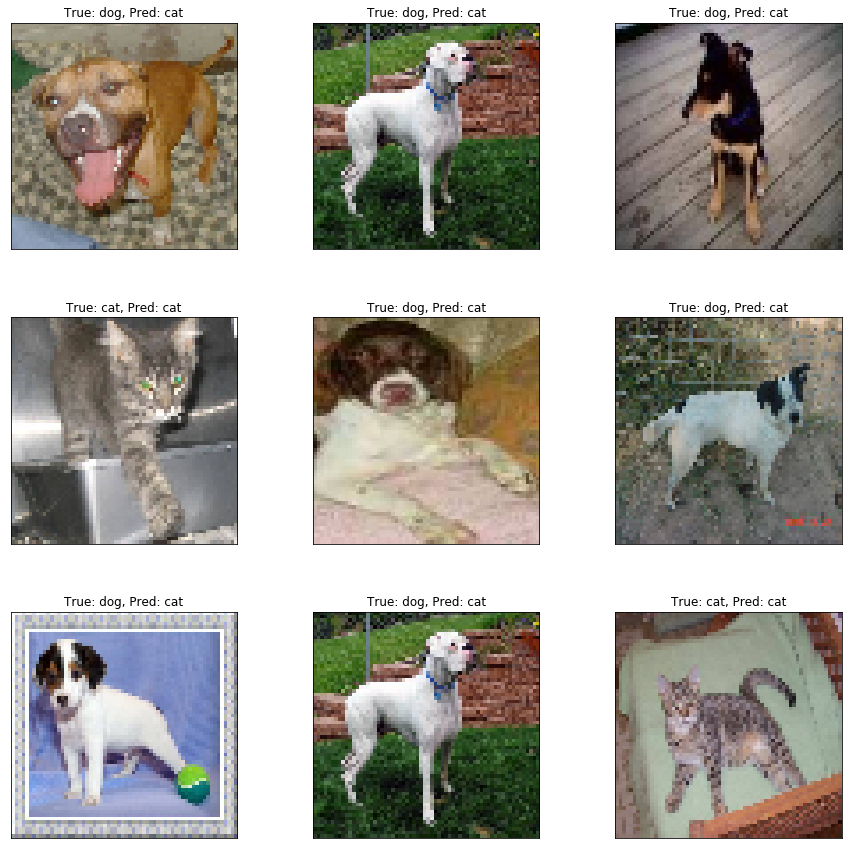

In [20]:
test_list ={
'X': [],
'y': []
}
import random
for x in range(9):
    rand_idx = random.randint(0, 999)
    test_list['X'].append(X_test[rand_idx])
    test_list['y'].append(y_test[rand_idx])
test_list['x'] = np.array(test_list['X'])
test_list['y'] = np.array(test_list['y'])

y_pred, acc = sess.run([pred, accuracy], feed_dict={X: test_list['X'], y: test_list['y']})
print('Accuracy of random 10 images: %.2f' % acc)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, ax in enumerate(axes.flat):
    print("i =",i)
    print("ax =",ax)
    print("axes.flat =",axes.flat)
    print("y_pred =",y_pred)
    
    ax.imshow(test_list['X'][i])
    mapping = ['cat', 'dog']
    cls_true  = int(test_list['y'][i])
    cls_pred = int(np.round(y_pred[i]))
    ax.set_title("True: {0}, Pred: {1}".format(mapping[cls_true], mapping[cls_pred]))
    ax.set_xticks([])
    ax.set_yticks([])